# This tutorial is used to test MLP model 

In [1]:
import sys
sys.path.append('../') 
from scripts.model import MLP_drug_cell_permutate
from scripts.util import DrugCombDataset_customized, get_datasets_simple
from scripts.evaluation import calculate_accuracy
from scripts.train_model import train_func
from torch.utils.data import DataLoader
from torch import optim, nn, no_grad
import scanpy as sc 
import random 
from sklearn import metrics
import numpy as np 
import joblib 
from joblib import Parallel, delayed 
import torch 
import pandas as pd 
import random 
import argparse 
import os 

### Define parameters

In [2]:
study_name = 'oneil'

# the device that you would use to run your code 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# data folder 
data_folder_path = "./data/" + str(study_name) + '/'
synergy_score = "loewe"

# folder to save your results  
save_folder = "results/" + str(study_name) + '/mlp/'

os.makedirs(save_folder, exist_ok=True)

# 
cell_feature = 'ge'
drug_feature = 'morgan'


# default permutation operation 
operation = 'additive'

# batch_size: the batch_size for training mlp model 
batch_size = 256

frac = 1.0
print('the study name: ', study_name, ' the fraction of data for training: ', frac)

the study name:  oneil  the fraction of data for training:  1.0


### Load data 

In [3]:
# ------------------------- Load data -----------------------------------
# load data, cell feature and drug features 

data_folder_path = "./data/" + str(study_name) + '/'

# ---- load cell line and drug features -----------------
cell_lines = pd.read_feather(data_folder_path + "cell_lines_" + str(cell_feature) + ".feather").set_index("cell_line_name")
cell_lines = cell_lines.astype(np.float32)
mol_mapping = joblib.load(data_folder_path + 'mol_' + str(drug_feature) +'_dic.joblib')

dataset = pd.read_feather(data_folder_path + f"loewe.feather")
dataset, train_dataset_tmp, test_dataset, cell_lines = get_datasets_simple(cell_lines, fold_number = 0, dataset = dataset)
print('percentage of positive samples in testing data', test_dataset.target.sum()/len(test_dataset))
drug_dim = mol_mapping['shape']
cell_dim = cell_lines.shape[1]
print('drug_dim and cell_dim: ', drug_dim, cell_dim)

percentage of positive samples in testing data 0.029781601588352084
drug_dim and cell_dim:  1024 908


### Hyperparameter define 


In [4]:
# ------------------------- define hyperparameters -----------------------------------

hparam = {
    'drug_dim': drug_dim, 
'cell_dim': cell_dim,
'hid_dim_1': 2**8,
'hid_dim': 2**7,
'lr': 1e-4,
'wd': 1e-6,
'max_epoch': 100,
'device': device,
'train_dataset': train_dataset_tmp,
'test_dataset': test_dataset,
'cell_lines': cell_lines, 
'mol_mapping': mol_mapping,
'drugs_feature': drug_feature,
'cell_feature': cell_feature,
'operation': operation,
'batch_size': batch_size
}

In [5]:
model = MLP_drug_cell_permutate(hparam=hparam)
model.to(hparam['device'])
# select fraction of traning data 
select = random.choices(range(len(train_dataset_tmp)), k = int(len(train_dataset_tmp)*frac))
train_dataset = train_dataset_tmp.iloc[select]
test_dataset = hparam['test_dataset']
print(len(train_dataset), len(test_dataset))
model, best_result, loss_dict = train_func(model, hparam, train_dataset, get_loss=True)


13606 1511


# Check the training accuracy

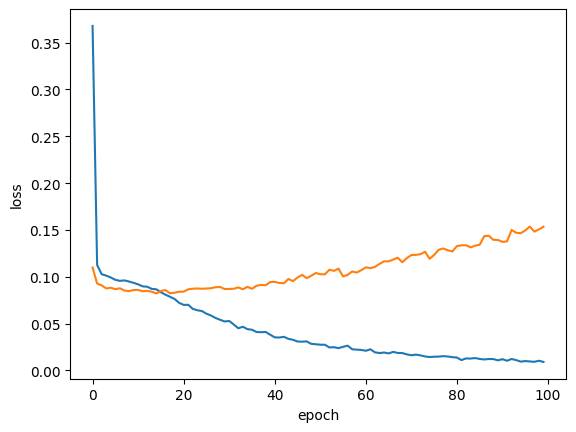

In [6]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_dict['epoch'], loss_dict['train_loss'], label = 'train')
plt.plot(loss_dict['epoch'], loss_dict['test_loss'], label = 'test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

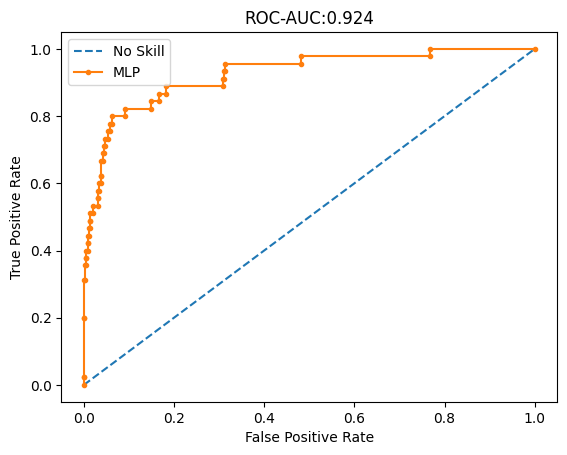

In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# calculate roc curves
testy = loss_dict['test_real_label']
lr_probs = loss_dict['test_pred']
ns_probs = [0 for _ in range(len(testy))] 
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
lr_auc = roc_auc_score(testy, lr_probs) 
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='MLP')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC-AUC:{lr_auc:0.3f}')
# show the legend
plt.legend()
# show the plot
plt.show()


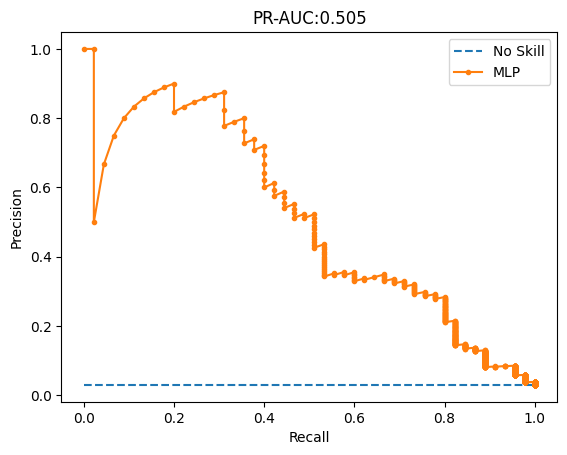

In [8]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_auc =  auc(lr_recall, lr_precision)

# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='MLP')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'PR-AUC:{lr_auc:0.3f}')

# show the legend
plt.legend()
# show the plot
plt.show()